In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import json
import seaborn as sns
import re
import calendar

%matplotlib inline 

I use a lot of temp df so I need to keep a running list of my actual df. Need to find a better way to fix this habit, probably not a good one to have.

* member_df
* inpatient_admin
* pcp_visit
* inpatient_pcp_df #merged inpatient and pcp
* doc_7_day #df that contains doc visit time diff calc
* readmission_30 
* facility_merge #pcp visit within 7 days broken out by hospital
* readmission_merge #readmission rate within 30 days broken out by hospital


In [2]:
member_df = pd.read_csv('../data/NSS_GreatCare_Members.csv')
member_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61519 entries, 0 to 61518
Data columns (total 63 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   Patient ID                                                       61519 non-null  object 
 1   Primary Plan ID                                                  61519 non-null  object 
 2   Primary Payor ID                                                 61519 non-null  object 
 3   Is Patient Alive                                                 61519 non-null  int64  
 4   Patient Age Integer                                              61519 non-null  int64  
 5   Patient Date of Birth                                            61519 non-null  object 
 6   Patient ZIP Code 5-Digit                                         61105 non-null  float64
 7   Count Primary Care Visits in Last 36 Mon

In [3]:
inpatient_admin = pd.read_csv('../data/NSS_Hospital_Inpatient_Admissions.csv')
inpatient_admin.head()

,Encounter ID,Patient ID,Encounter Primary Payor ID,Encounter Primary Plan ID,Facility Provider ID,Attending Provider ID,Attending Provider NPI,Facility Provider NPI,Encounter Start Date,Encounter End Date,...,CMS Admit Source Code,CMS Patient Discharge Status Code,CMS Place of Service Code,Principal Discharge Diagnosis ICD-9-CM Code,Principal Discharge Diagnosis ICD-9-CM Description,Principal Discharge Diagnosis ICD-10-CM Code,Principal Discharge Diagnosis ICD-10-CM Description,Primary Plan Allowed Amount,Primary Plan Paid Amount,Patient Paid Amount
0,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,DS1|1,DS1|5047W,DS1|NPI|1306890389,DS1|NPI|1417170523,1.417171e+09,1306890389,2013-01-12,2013-01-14,...,1,1,21.0,NaN,NaN,O70.0,First degree perineal laceration during delivery,0,6620.72,250.0
1,HIA|DS1|10043|DS1|NPI|1902803315|1,DS1|10043,DS1|1,DS1|5047Y,DS1|NPI|1902803315,DS1|NPI|1669599197,1.669599e+09,1902803315,2014-01-05,2014-01-12,...,1,1,21.0,348.4,Compression of brain,NaN,NaN,0,46465.40,250.0
2,HIA|DS1|10073|DS1|NPI|1902803315|1,DS1|10073,DS1|1,DS1|5047X,DS1|NPI|1902803315,DS1|NPI|1407880511,1.407881e+09,1902803315,2012-06-13,2012-06-21,...,1,1,21.0,NaN,NaN,K91.71,Accidental puncture and laceration of a digest...,0,43879.13,250.0
3,HIA|DS1|10101|DS1|NPI|1427055839|1,DS1|10101,DS1|1,DS1|5047W,DS1|NPI|1427055839,DS1|NPI|1407008907,1.407009e+09,1427055839,2012-12-06,2012-12-09,...,1,1,21.0,NaN,NaN,O70.1,Second degree perineal laceration during delivery,0,14800.00,250.0
4,HIA|DS1|10118|DS1|NPI|1992818256|1,DS1|10118,DS1|1,DS1|5047W,DS1|NPI|1992818256,DS1|NPI|1518045608,1.518046e+09,1992818256,2015-03-11,2015-03-14,...,2,1,NaN,NaN,NaN,F32.9,"Major depressive disorder, single episode, uns...",0,0.00,0.0


In [4]:
# Converting some data types, specifically the dates

inpatient_admin[['Encounter Start Date','Encounter End Date']] = inpatient_admin[['Encounter Start Date','Encounter End Date']].apply(pd.to_datetime)
inpatient_admin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6213 entries, 0 to 6212
Data columns (total 23 columns):
 #   Column                                               Non-Null Count  Dtype         
---  ------                                               --------------  -----         
 0   Encounter ID                                         6213 non-null   object        
 1   Patient ID                                           6213 non-null   object        
 2   Encounter Primary Payor ID                           6213 non-null   object        
 3   Encounter Primary Plan ID                            6213 non-null   object        
 4   Facility Provider ID                                 6213 non-null   object        
 5   Attending Provider ID                                5884 non-null   object        
 6   Attending Provider NPI                               5884 non-null   float64       
 7   Facility Provider NPI                                6213 non-null   object        
 8 

In [5]:
pcp_visit = pd.read_csv('../data/NSS_PrimaryCare_Office_Visits.csv',low_memory = False)
pcp_visit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231373 entries, 0 to 231372
Data columns (total 18 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   Encounter ID                                   231373 non-null  object 
 1   Patient ID                                     231373 non-null  object 
 2   Service Provider ID                            230599 non-null  object 
 3   Attending Provider ID                          39644 non-null   object 
 4   Provider Group Provider ID                     227644 non-null  object 
 5   Facility Provider ID                           39756 non-null   object 
 6   Encounter Primary Payor ID                     231373 non-null  object 
 7   Encounter Primary Plan ID                      231373 non-null  object 
 8   Attending Provider NPI                         39644 non-null   float64
 9   Facility Provider NPI                

In [6]:
pcp_visit['Encounter Date'] = pd.to_datetime(pcp_visit['Encounter Date'])
pcp_visit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231373 entries, 0 to 231372
Data columns (total 18 columns):
 #   Column                                         Non-Null Count   Dtype         
---  ------                                         --------------   -----         
 0   Encounter ID                                   231373 non-null  object        
 1   Patient ID                                     231373 non-null  object        
 2   Service Provider ID                            230599 non-null  object        
 3   Attending Provider ID                          39644 non-null   object        
 4   Provider Group Provider ID                     227644 non-null  object        
 5   Facility Provider ID                           39756 non-null   object        
 6   Encounter Primary Payor ID                     231373 non-null  object        
 7   Encounter Primary Plan ID                      231373 non-null  object        
 8   Attending Provider NPI                      

# Q2. What percent of patients have a PCP visit within a week of discharge?

In [7]:
# Going to start on question 2 cause I think that's easier

# Gonna pick the columns I need from 'Inpatient' and 'PCP' and then join them

x = inpatient_admin[['Encounter ID','Patient ID', 'Encounter Start Date', 'Encounter End Date']]
y = pcp_visit[['Encounter ID','Patient ID', 'Encounter Date']]

print(x)
print(y)

                            Encounter ID Patient ID Encounter Start Date  \
0     HIA|DS1|10033|DS1|NPI|1306890389|1  DS1|10033           2013-01-12   
1     HIA|DS1|10043|DS1|NPI|1902803315|1  DS1|10043           2014-01-05   
2     HIA|DS1|10073|DS1|NPI|1902803315|1  DS1|10073           2012-06-13   
3     HIA|DS1|10101|DS1|NPI|1427055839|1  DS1|10101           2012-12-06   
4     HIA|DS1|10118|DS1|NPI|1992818256|1  DS1|10118           2015-03-11   
...                                  ...        ...                  ...   
6208   HIA|DS1|9979|DS1|NPI|1689772592|1   DS1|9979           2015-02-06   
6209   HIA|DS1|9981|DS1|NPI|1427055839|1   DS1|9981           2014-08-07   
6210   HIA|DS1|9994|DS1|NPI|1689608150|1   DS1|9994           2015-11-21   
6211   HIA|DS1|9994|DS1|NPI|1689608150|2   DS1|9994           2015-11-24   
6212   HIA|DS1|9996|DS1|NPI|1033298617|1   DS1|9996           2010-03-28   

     Encounter End Date  
0            2013-01-14  
1            2014-01-12  
2        

In [8]:
# Merge. There will be duplicates because of the mismatch dates between PCP visits and Inpatient Visits.

inpatient_pcp_df = x.merge(y, how = 'left', on = 'Patient ID')
inpatient_pcp_df

,Encounter ID_x,Patient ID,Encounter Start Date,Encounter End Date,Encounter ID_y,Encounter Date
0,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,2013-01-12,2013-01-14,COV|PBSL|DS1|10033|P|1228384|1043427248|1|SHIFTED,2015-12-08
1,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,2013-01-12,2013-01-14,COV|PBSL|DS1|10033|P|1326684|1043427248|1|SHIFTED,2012-06-18
2,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,2013-01-12,2013-01-14,COV|PBSL|DS1|10033|P|155317|1043427248|1|SHIFTED,2014-06-10
3,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,2013-01-12,2013-01-14,COV|PBSL|DS1|10033|P|439093|1043427248|1|SHIFTED,2014-09-28
4,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,2013-01-12,2013-01-14,COV|PBSL|DS1|10033|P|711310|1043427248|1|SHIFTED,2014-03-16
...,...,...,...,...,...,...
44093,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,2015-11-24,2015-11-27,COV|PCSL|DS1|9994|P|1238517|1407058787|2,2015-12-05
44094,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,2015-11-24,2015-11-27,COV|PCSL|DS1|9994|P|302749|1407058787|2,2015-12-13
44095,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,2015-11-24,2015-11-27,COV|PCSL|DS1|9994|P|781849|1205884392|1,2014-05-18
44096,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,2015-11-24,2015-11-27,COV|PCSL|DS1|9994|P|93182|1043427248|1,2013-07-20


In [9]:
# Time to find if they visited the pcp after hospital

inpatient_pcp_df['7_Days'] = inpatient_pcp_df['Encounter Date'] - inpatient_pcp_df['Encounter End Date']
inpatient_pcp_df

,Encounter ID_x,Patient ID,Encounter Start Date,Encounter End Date,Encounter ID_y,Encounter Date,7_Days
0,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,2013-01-12,2013-01-14,COV|PBSL|DS1|10033|P|1228384|1043427248|1|SHIFTED,2015-12-08,1058 days
1,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,2013-01-12,2013-01-14,COV|PBSL|DS1|10033|P|1326684|1043427248|1|SHIFTED,2012-06-18,-210 days
2,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,2013-01-12,2013-01-14,COV|PBSL|DS1|10033|P|155317|1043427248|1|SHIFTED,2014-06-10,512 days
3,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,2013-01-12,2013-01-14,COV|PBSL|DS1|10033|P|439093|1043427248|1|SHIFTED,2014-09-28,622 days
4,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,2013-01-12,2013-01-14,COV|PBSL|DS1|10033|P|711310|1043427248|1|SHIFTED,2014-03-16,426 days
...,...,...,...,...,...,...,...
44093,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,2015-11-24,2015-11-27,COV|PCSL|DS1|9994|P|1238517|1407058787|2,2015-12-05,8 days
44094,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,2015-11-24,2015-11-27,COV|PCSL|DS1|9994|P|302749|1407058787|2,2015-12-13,16 days
44095,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,2015-11-24,2015-11-27,COV|PCSL|DS1|9994|P|781849|1205884392|1,2014-05-18,-558 days
44096,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,2015-11-24,2015-11-27,COV|PCSL|DS1|9994|P|93182|1043427248|1,2013-07-20,-860 days


In [10]:
# Looping through the time difference column to find any that are within 7days. 

t = []

for i in inpatient_pcp_df['7_Days']:
    if (i <= dt.timedelta(days=7)) and (i >= dt.timedelta(days=0)) :
        t.append('yes')
    else:
        t.append('no')

In [11]:
# Adding my column 

inpatient_pcp_df['within_7'] = t

In [12]:
inpatient_pcp_df

,Encounter ID_x,Patient ID,Encounter Start Date,Encounter End Date,Encounter ID_y,Encounter Date,7_Days,within_7
0,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,2013-01-12,2013-01-14,COV|PBSL|DS1|10033|P|1228384|1043427248|1|SHIFTED,2015-12-08,1058 days,no
1,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,2013-01-12,2013-01-14,COV|PBSL|DS1|10033|P|1326684|1043427248|1|SHIFTED,2012-06-18,-210 days,no
2,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,2013-01-12,2013-01-14,COV|PBSL|DS1|10033|P|155317|1043427248|1|SHIFTED,2014-06-10,512 days,no
3,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,2013-01-12,2013-01-14,COV|PBSL|DS1|10033|P|439093|1043427248|1|SHIFTED,2014-09-28,622 days,no
4,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,2013-01-12,2013-01-14,COV|PBSL|DS1|10033|P|711310|1043427248|1|SHIFTED,2014-03-16,426 days,no
...,...,...,...,...,...,...,...,...
44093,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,2015-11-24,2015-11-27,COV|PCSL|DS1|9994|P|1238517|1407058787|2,2015-12-05,8 days,no
44094,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,2015-11-24,2015-11-27,COV|PCSL|DS1|9994|P|302749|1407058787|2,2015-12-13,16 days,no
44095,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,2015-11-24,2015-11-27,COV|PCSL|DS1|9994|P|781849|1205884392|1,2014-05-18,-558 days,no
44096,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,2015-11-24,2015-11-27,COV|PCSL|DS1|9994|P|93182|1043427248|1,2013-07-20,-860 days,no


In [13]:
# There are 2362 instances in which a patient visited their PCP within 7 days of an Inpatient visit. 

inpatient_pcp_df['within_7'].value_counts()

no     41723
yes     2375
Name: within_7, dtype: int64

# So there are duplicates

There seems to be duplicate entries because of multiple doctor visits. Example: Patient is discharged on 1/10/2021 and they visit their PCP on 1/12, 1/14, and 1/16. \
This creates 3 duplicate entries for the 1 hospital visit \
I could elminate this by counting each 'Encounter ID_x' as 1 instance \
\
I will clean up down below

In [14]:
# To finish Q2, I will filter out all of the 'no' and be left with only 'yes'. I can merge that back to the original 'Inpatient' DF to find a %

y = inpatient_pcp_df.loc[inpatient_pcp_df['within_7'] == 'yes']

# Using this filtered df, I will remove duplicates mentioned in my Markdown above. This way, each hospital encounter will only count 1 time if they visit a doc after.
y = y.drop_duplicates(subset='Encounter ID_x', keep='first')
y

,Encounter ID_x,Patient ID,Encounter Start Date,Encounter End Date,Encounter ID_y,Encounter Date,7_Days,within_7
17,HIA|DS1|10043|DS1|NPI|1902803315|1,DS1|10043,2014-01-05,2014-01-12,COV|PBSL|DS1|10043|P|538933|1043427248|1|SHIFTED,2014-01-12,0 days,yes
28,HIA|DS1|10073|DS1|NPI|1902803315|1,DS1|10073,2012-06-13,2012-06-21,COV|PBSL|DS1|10073|P|301709|1043427248|1|SHIFTED,2012-06-27,6 days,yes
50,HIA|DS1|10101|DS1|NPI|1427055839|1,DS1|10101,2012-12-06,2012-12-09,COV|PCSL|DS1|10101|P|1189971|1043427248|1,2012-12-12,3 days,yes
231,HIA|DS1|10303|DS1|NPI|1710918545|1,DS1|10303,2012-06-21,2012-06-24,COV|PBSL|DS1|10303|P|10896|1912987553|1,2012-06-30,6 days,yes
247,HIA|DS1|10305|DS1|NPI|1184722779|1,DS1|10305,2014-05-10,2014-05-12,COV|PBSL|DS1|10305|P|823298|1184722779|1,2014-05-13,1 days,yes
...,...,...,...,...,...,...,...,...
44039,HIA|DS1|9943|DS1|NPI|1184722779|3,DS1|9943,2014-10-28,2014-10-30,COV|PCSL|DS1|9943|P|1315984|1184722779|1,2014-11-03,4 days,yes
44051,HIA|DS1|9945|DS1|NPI|1902803315|1,DS1|9945,2013-02-09,2013-02-11,COV|PCSL|DS1|9945|P|840374|1043427248|1,2013-02-14,3 days,yes
44067,HIA|DS1|9978|DS1|NPI|1427055839|1,DS1|9978,2015-09-01,2015-09-05,COV|PCSL|DS1|9978|P|696226|1043427248|1,2015-09-11,6 days,yes
44071,HIA|DS1|9979|DS1|NPI|1689772592|1,DS1|9979,2015-02-06,2015-02-11,COV|PCSL|DS1|9979|P|281365|1477666352|1,2015-02-15,4 days,yes


In [15]:
# Need to clean up my columns to get ready to merge

w = y[['Encounter ID_x','Encounter Date','within_7']]
w

,Encounter ID_x,Encounter Date,within_7
17,HIA|DS1|10043|DS1|NPI|1902803315|1,2014-01-12,yes
28,HIA|DS1|10073|DS1|NPI|1902803315|1,2012-06-27,yes
50,HIA|DS1|10101|DS1|NPI|1427055839|1,2012-12-12,yes
231,HIA|DS1|10303|DS1|NPI|1710918545|1,2012-06-30,yes
247,HIA|DS1|10305|DS1|NPI|1184722779|1,2014-05-13,yes
...,...,...,...
44039,HIA|DS1|9943|DS1|NPI|1184722779|3,2014-11-03,yes
44051,HIA|DS1|9945|DS1|NPI|1902803315|1,2013-02-14,yes
44067,HIA|DS1|9978|DS1|NPI|1427055839|1,2015-09-11,yes
44071,HIA|DS1|9979|DS1|NPI|1689772592|1,2015-02-15,yes


In [16]:
# Merge

doc_7_day = inpatient_admin.merge(w, how = 'left', left_on = 'Encounter ID', right_on = 'Encounter ID_x')
doc_7_day

,Encounter ID,Patient ID,Encounter Primary Payor ID,Encounter Primary Plan ID,Facility Provider ID,Attending Provider ID,Attending Provider NPI,Facility Provider NPI,Encounter Start Date,Encounter End Date,...,Principal Discharge Diagnosis ICD-9-CM Code,Principal Discharge Diagnosis ICD-9-CM Description,Principal Discharge Diagnosis ICD-10-CM Code,Principal Discharge Diagnosis ICD-10-CM Description,Primary Plan Allowed Amount,Primary Plan Paid Amount,Patient Paid Amount,Encounter ID_x,Encounter Date,within_7
0,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,DS1|1,DS1|5047W,DS1|NPI|1306890389,DS1|NPI|1417170523,1.417171e+09,1306890389,2013-01-12,2013-01-14,...,NaN,NaN,O70.0,First degree perineal laceration during delivery,0,6620.72,250.0,NaN,NaT,NaN
1,HIA|DS1|10043|DS1|NPI|1902803315|1,DS1|10043,DS1|1,DS1|5047Y,DS1|NPI|1902803315,DS1|NPI|1669599197,1.669599e+09,1902803315,2014-01-05,2014-01-12,...,348.4,Compression of brain,NaN,NaN,0,46465.40,250.0,HIA|DS1|10043|DS1|NPI|1902803315|1,2014-01-12,yes
2,HIA|DS1|10073|DS1|NPI|1902803315|1,DS1|10073,DS1|1,DS1|5047X,DS1|NPI|1902803315,DS1|NPI|1407880511,1.407881e+09,1902803315,2012-06-13,2012-06-21,...,NaN,NaN,K91.71,Accidental puncture and laceration of a digest...,0,43879.13,250.0,HIA|DS1|10073|DS1|NPI|1902803315|1,2012-06-27,yes
3,HIA|DS1|10101|DS1|NPI|1427055839|1,DS1|10101,DS1|1,DS1|5047W,DS1|NPI|1427055839,DS1|NPI|1407008907,1.407009e+09,1427055839,2012-12-06,2012-12-09,...,NaN,NaN,O70.1,Second degree perineal laceration during delivery,0,14800.00,250.0,HIA|DS1|10101|DS1|NPI|1427055839|1,2012-12-12,yes
4,HIA|DS1|10118|DS1|NPI|1992818256|1,DS1|10118,DS1|1,DS1|5047W,DS1|NPI|1992818256,DS1|NPI|1518045608,1.518046e+09,1992818256,2015-03-11,2015-03-14,...,NaN,NaN,F32.9,"Major depressive disorder, single episode, uns...",0,0.00,0.0,NaN,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6208,HIA|DS1|9979|DS1|NPI|1689772592|1,DS1|9979,DS1|1,DS1|5047X,DS1|NPI|1689772592,DS1|NPI|1720043417,1.720043e+09,1689772592,2015-02-06,2015-02-11,...,NaN,NaN,O44.13,"Complete placenta previa with hemorrhage, thir...",0,23598.00,250.0,HIA|DS1|9979|DS1|NPI|1689772592|1,2015-02-15,yes
6209,HIA|DS1|9981|DS1|NPI|1427055839|1,DS1|9981,DS1|1,DS1|5047W,DS1|NPI|1427055839,DS1|NPI|1215968474,1.215968e+09,1427055839,2014-08-07,2014-08-10,...,664.11,"Second-degree perineal laceration, delivered, ...",NaN,NaN,0,14800.00,250.0,HIA|DS1|9981|DS1|NPI|1427055839|1,2014-08-11,yes
6210,HIA|DS1|9994|DS1|NPI|1689608150|1,DS1|9994,DS1|1,DS1|5047W,DS1|NPI|1689608150,DS1|NPI|1861831836,1.861832e+09,1689608150,2015-11-21,2015-11-23,...,NaN,NaN,O76,Abnormality in fetal heart rate and rhythm com...,0,17919.75,250.0,NaN,NaT,NaN
6211,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,DS1|1,DS1|5047W,DS1|NPI|1689608150,DS1|NPI|1750544516,1.750545e+09,1689608150,2015-11-24,2015-11-27,...,NaN,NaN,O42.92,"Full-term premature rupture of membranes, unsp...",0,19919.42,250.0,NaN,NaT,NaN


In [17]:
# Little bit of cleaning up. Dropping a column and filling in 'NaN' with 'no'.

doc_7_day = doc_7_day.drop(['Encounter ID_x'], axis = 1)
doc_7_day['within_7'] = doc_7_day['within_7'].fillna('no')
doc_7_day

,Encounter ID,Patient ID,Encounter Primary Payor ID,Encounter Primary Plan ID,Facility Provider ID,Attending Provider ID,Attending Provider NPI,Facility Provider NPI,Encounter Start Date,Encounter End Date,...,CMS Place of Service Code,Principal Discharge Diagnosis ICD-9-CM Code,Principal Discharge Diagnosis ICD-9-CM Description,Principal Discharge Diagnosis ICD-10-CM Code,Principal Discharge Diagnosis ICD-10-CM Description,Primary Plan Allowed Amount,Primary Plan Paid Amount,Patient Paid Amount,Encounter Date,within_7
0,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,DS1|1,DS1|5047W,DS1|NPI|1306890389,DS1|NPI|1417170523,1.417171e+09,1306890389,2013-01-12,2013-01-14,...,21.0,NaN,NaN,O70.0,First degree perineal laceration during delivery,0,6620.72,250.0,NaT,no
1,HIA|DS1|10043|DS1|NPI|1902803315|1,DS1|10043,DS1|1,DS1|5047Y,DS1|NPI|1902803315,DS1|NPI|1669599197,1.669599e+09,1902803315,2014-01-05,2014-01-12,...,21.0,348.4,Compression of brain,NaN,NaN,0,46465.40,250.0,2014-01-12,yes
2,HIA|DS1|10073|DS1|NPI|1902803315|1,DS1|10073,DS1|1,DS1|5047X,DS1|NPI|1902803315,DS1|NPI|1407880511,1.407881e+09,1902803315,2012-06-13,2012-06-21,...,21.0,NaN,NaN,K91.71,Accidental puncture and laceration of a digest...,0,43879.13,250.0,2012-06-27,yes
3,HIA|DS1|10101|DS1|NPI|1427055839|1,DS1|10101,DS1|1,DS1|5047W,DS1|NPI|1427055839,DS1|NPI|1407008907,1.407009e+09,1427055839,2012-12-06,2012-12-09,...,21.0,NaN,NaN,O70.1,Second degree perineal laceration during delivery,0,14800.00,250.0,2012-12-12,yes
4,HIA|DS1|10118|DS1|NPI|1992818256|1,DS1|10118,DS1|1,DS1|5047W,DS1|NPI|1992818256,DS1|NPI|1518045608,1.518046e+09,1992818256,2015-03-11,2015-03-14,...,NaN,NaN,NaN,F32.9,"Major depressive disorder, single episode, uns...",0,0.00,0.0,NaT,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6208,HIA|DS1|9979|DS1|NPI|1689772592|1,DS1|9979,DS1|1,DS1|5047X,DS1|NPI|1689772592,DS1|NPI|1720043417,1.720043e+09,1689772592,2015-02-06,2015-02-11,...,21.0,NaN,NaN,O44.13,"Complete placenta previa with hemorrhage, thir...",0,23598.00,250.0,2015-02-15,yes
6209,HIA|DS1|9981|DS1|NPI|1427055839|1,DS1|9981,DS1|1,DS1|5047W,DS1|NPI|1427055839,DS1|NPI|1215968474,1.215968e+09,1427055839,2014-08-07,2014-08-10,...,21.0,664.11,"Second-degree perineal laceration, delivered, ...",NaN,NaN,0,14800.00,250.0,2014-08-11,yes
6210,HIA|DS1|9994|DS1|NPI|1689608150|1,DS1|9994,DS1|1,DS1|5047W,DS1|NPI|1689608150,DS1|NPI|1861831836,1.861832e+09,1689608150,2015-11-21,2015-11-23,...,21.0,NaN,NaN,O76,Abnormality in fetal heart rate and rhythm com...,0,17919.75,250.0,NaT,no
6211,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,DS1|1,DS1|5047W,DS1|NPI|1689608150,DS1|NPI|1750544516,1.750545e+09,1689608150,2015-11-24,2015-11-27,...,21.0,NaN,NaN,O42.92,"Full-term premature rupture of membranes, unsp...",0,19919.42,250.0,NaT,no


In [92]:
# 1864(doc visits) out of the total 6213(hospital visits). 30.00% went to their PCP within 7 days after the hospital discharge.

print(doc_7_day['within_7'].value_counts())
pcp_rate = (1864/6213*100)
print(pcp_rate)

no     4349
yes    1864
Name: within_7, dtype: int64
30.001609528408174


# Q1. What is our 30-day all cause readmission rate across hospitals our members are admitted to?
\
Code from Debbie:\
thirtyadm['next_adm']=thirtyadm.sort_values(by=['start_date'],ascending=True).groupby(['patient_id'])['start_date'].shift(-1)


In [19]:
# Working in a temp variable so I don't mess up my original df.
q = inpatient_admin
q

,Encounter ID,Patient ID,Encounter Primary Payor ID,Encounter Primary Plan ID,Facility Provider ID,Attending Provider ID,Attending Provider NPI,Facility Provider NPI,Encounter Start Date,Encounter End Date,...,CMS Admit Source Code,CMS Patient Discharge Status Code,CMS Place of Service Code,Principal Discharge Diagnosis ICD-9-CM Code,Principal Discharge Diagnosis ICD-9-CM Description,Principal Discharge Diagnosis ICD-10-CM Code,Principal Discharge Diagnosis ICD-10-CM Description,Primary Plan Allowed Amount,Primary Plan Paid Amount,Patient Paid Amount
0,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,DS1|1,DS1|5047W,DS1|NPI|1306890389,DS1|NPI|1417170523,1.417171e+09,1306890389,2013-01-12,2013-01-14,...,1,1,21.0,NaN,NaN,O70.0,First degree perineal laceration during delivery,0,6620.72,250.0
1,HIA|DS1|10043|DS1|NPI|1902803315|1,DS1|10043,DS1|1,DS1|5047Y,DS1|NPI|1902803315,DS1|NPI|1669599197,1.669599e+09,1902803315,2014-01-05,2014-01-12,...,1,1,21.0,348.4,Compression of brain,NaN,NaN,0,46465.40,250.0
2,HIA|DS1|10073|DS1|NPI|1902803315|1,DS1|10073,DS1|1,DS1|5047X,DS1|NPI|1902803315,DS1|NPI|1407880511,1.407881e+09,1902803315,2012-06-13,2012-06-21,...,1,1,21.0,NaN,NaN,K91.71,Accidental puncture and laceration of a digest...,0,43879.13,250.0
3,HIA|DS1|10101|DS1|NPI|1427055839|1,DS1|10101,DS1|1,DS1|5047W,DS1|NPI|1427055839,DS1|NPI|1407008907,1.407009e+09,1427055839,2012-12-06,2012-12-09,...,1,1,21.0,NaN,NaN,O70.1,Second degree perineal laceration during delivery,0,14800.00,250.0
4,HIA|DS1|10118|DS1|NPI|1992818256|1,DS1|10118,DS1|1,DS1|5047W,DS1|NPI|1992818256,DS1|NPI|1518045608,1.518046e+09,1992818256,2015-03-11,2015-03-14,...,2,1,NaN,NaN,NaN,F32.9,"Major depressive disorder, single episode, uns...",0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6208,HIA|DS1|9979|DS1|NPI|1689772592|1,DS1|9979,DS1|1,DS1|5047X,DS1|NPI|1689772592,DS1|NPI|1720043417,1.720043e+09,1689772592,2015-02-06,2015-02-11,...,2,6,21.0,NaN,NaN,O44.13,"Complete placenta previa with hemorrhage, thir...",0,23598.00,250.0
6209,HIA|DS1|9981|DS1|NPI|1427055839|1,DS1|9981,DS1|1,DS1|5047W,DS1|NPI|1427055839,DS1|NPI|1215968474,1.215968e+09,1427055839,2014-08-07,2014-08-10,...,1,1,21.0,664.11,"Second-degree perineal laceration, delivered, ...",NaN,NaN,0,14800.00,250.0
6210,HIA|DS1|9994|DS1|NPI|1689608150|1,DS1|9994,DS1|1,DS1|5047W,DS1|NPI|1689608150,DS1|NPI|1861831836,1.861832e+09,1689608150,2015-11-21,2015-11-23,...,1,1,21.0,NaN,NaN,O76,Abnormality in fetal heart rate and rhythm com...,0,17919.75,250.0
6211,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,DS1|1,DS1|5047W,DS1|NPI|1689608150,DS1|NPI|1750544516,1.750545e+09,1689608150,2015-11-24,2015-11-27,...,1,1,21.0,NaN,NaN,O42.92,"Full-term premature rupture of membranes, unsp...",0,19919.42,250.0


In [20]:
# Code from Debbie works great. It adds a column and puts the next date they visited the hospital. I can reuse my work from the doctor calculations to find 30 day readmission.

q['next_admin'] =  inpatient_admin.sort_values(by=['Encounter Start Date'],ascending=True).groupby(['Patient ID'])['Encounter Start Date'].shift(-1)
q

,Encounter ID,Patient ID,Encounter Primary Payor ID,Encounter Primary Plan ID,Facility Provider ID,Attending Provider ID,Attending Provider NPI,Facility Provider NPI,Encounter Start Date,Encounter End Date,...,CMS Patient Discharge Status Code,CMS Place of Service Code,Principal Discharge Diagnosis ICD-9-CM Code,Principal Discharge Diagnosis ICD-9-CM Description,Principal Discharge Diagnosis ICD-10-CM Code,Principal Discharge Diagnosis ICD-10-CM Description,Primary Plan Allowed Amount,Primary Plan Paid Amount,Patient Paid Amount,next_admin
0,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,DS1|1,DS1|5047W,DS1|NPI|1306890389,DS1|NPI|1417170523,1.417171e+09,1306890389,2013-01-12,2013-01-14,...,1,21.0,NaN,NaN,O70.0,First degree perineal laceration during delivery,0,6620.72,250.0,NaT
1,HIA|DS1|10043|DS1|NPI|1902803315|1,DS1|10043,DS1|1,DS1|5047Y,DS1|NPI|1902803315,DS1|NPI|1669599197,1.669599e+09,1902803315,2014-01-05,2014-01-12,...,1,21.0,348.4,Compression of brain,NaN,NaN,0,46465.40,250.0,NaT
2,HIA|DS1|10073|DS1|NPI|1902803315|1,DS1|10073,DS1|1,DS1|5047X,DS1|NPI|1902803315,DS1|NPI|1407880511,1.407881e+09,1902803315,2012-06-13,2012-06-21,...,1,21.0,NaN,NaN,K91.71,Accidental puncture and laceration of a digest...,0,43879.13,250.0,NaT
3,HIA|DS1|10101|DS1|NPI|1427055839|1,DS1|10101,DS1|1,DS1|5047W,DS1|NPI|1427055839,DS1|NPI|1407008907,1.407009e+09,1427055839,2012-12-06,2012-12-09,...,1,21.0,NaN,NaN,O70.1,Second degree perineal laceration during delivery,0,14800.00,250.0,NaT
4,HIA|DS1|10118|DS1|NPI|1992818256|1,DS1|10118,DS1|1,DS1|5047W,DS1|NPI|1992818256,DS1|NPI|1518045608,1.518046e+09,1992818256,2015-03-11,2015-03-14,...,1,NaN,NaN,NaN,F32.9,"Major depressive disorder, single episode, uns...",0,0.00,0.0,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6208,HIA|DS1|9979|DS1|NPI|1689772592|1,DS1|9979,DS1|1,DS1|5047X,DS1|NPI|1689772592,DS1|NPI|1720043417,1.720043e+09,1689772592,2015-02-06,2015-02-11,...,6,21.0,NaN,NaN,O44.13,"Complete placenta previa with hemorrhage, thir...",0,23598.00,250.0,NaT
6209,HIA|DS1|9981|DS1|NPI|1427055839|1,DS1|9981,DS1|1,DS1|5047W,DS1|NPI|1427055839,DS1|NPI|1215968474,1.215968e+09,1427055839,2014-08-07,2014-08-10,...,1,21.0,664.11,"Second-degree perineal laceration, delivered, ...",NaN,NaN,0,14800.00,250.0,NaT
6210,HIA|DS1|9994|DS1|NPI|1689608150|1,DS1|9994,DS1|1,DS1|5047W,DS1|NPI|1689608150,DS1|NPI|1861831836,1.861832e+09,1689608150,2015-11-21,2015-11-23,...,1,21.0,NaN,NaN,O76,Abnormality in fetal heart rate and rhythm com...,0,17919.75,250.0,2015-11-24
6211,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,DS1|1,DS1|5047W,DS1|NPI|1689608150,DS1|NPI|1750544516,1.750545e+09,1689608150,2015-11-24,2015-11-27,...,1,21.0,NaN,NaN,O42.92,"Full-term premature rupture of membranes, unsp...",0,19919.42,250.0,NaT


In [21]:
# Lets add a column to see the time diff between end of encounter to next admission

q['time_diff'] = q['next_admin'] - q['Encounter End Date']
q

,Encounter ID,Patient ID,Encounter Primary Payor ID,Encounter Primary Plan ID,Facility Provider ID,Attending Provider ID,Attending Provider NPI,Facility Provider NPI,Encounter Start Date,Encounter End Date,...,CMS Place of Service Code,Principal Discharge Diagnosis ICD-9-CM Code,Principal Discharge Diagnosis ICD-9-CM Description,Principal Discharge Diagnosis ICD-10-CM Code,Principal Discharge Diagnosis ICD-10-CM Description,Primary Plan Allowed Amount,Primary Plan Paid Amount,Patient Paid Amount,next_admin,time_diff
0,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,DS1|1,DS1|5047W,DS1|NPI|1306890389,DS1|NPI|1417170523,1.417171e+09,1306890389,2013-01-12,2013-01-14,...,21.0,NaN,NaN,O70.0,First degree perineal laceration during delivery,0,6620.72,250.0,NaT,NaT
1,HIA|DS1|10043|DS1|NPI|1902803315|1,DS1|10043,DS1|1,DS1|5047Y,DS1|NPI|1902803315,DS1|NPI|1669599197,1.669599e+09,1902803315,2014-01-05,2014-01-12,...,21.0,348.4,Compression of brain,NaN,NaN,0,46465.40,250.0,NaT,NaT
2,HIA|DS1|10073|DS1|NPI|1902803315|1,DS1|10073,DS1|1,DS1|5047X,DS1|NPI|1902803315,DS1|NPI|1407880511,1.407881e+09,1902803315,2012-06-13,2012-06-21,...,21.0,NaN,NaN,K91.71,Accidental puncture and laceration of a digest...,0,43879.13,250.0,NaT,NaT
3,HIA|DS1|10101|DS1|NPI|1427055839|1,DS1|10101,DS1|1,DS1|5047W,DS1|NPI|1427055839,DS1|NPI|1407008907,1.407009e+09,1427055839,2012-12-06,2012-12-09,...,21.0,NaN,NaN,O70.1,Second degree perineal laceration during delivery,0,14800.00,250.0,NaT,NaT
4,HIA|DS1|10118|DS1|NPI|1992818256|1,DS1|10118,DS1|1,DS1|5047W,DS1|NPI|1992818256,DS1|NPI|1518045608,1.518046e+09,1992818256,2015-03-11,2015-03-14,...,NaN,NaN,NaN,F32.9,"Major depressive disorder, single episode, uns...",0,0.00,0.0,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6208,HIA|DS1|9979|DS1|NPI|1689772592|1,DS1|9979,DS1|1,DS1|5047X,DS1|NPI|1689772592,DS1|NPI|1720043417,1.720043e+09,1689772592,2015-02-06,2015-02-11,...,21.0,NaN,NaN,O44.13,"Complete placenta previa with hemorrhage, thir...",0,23598.00,250.0,NaT,NaT
6209,HIA|DS1|9981|DS1|NPI|1427055839|1,DS1|9981,DS1|1,DS1|5047W,DS1|NPI|1427055839,DS1|NPI|1215968474,1.215968e+09,1427055839,2014-08-07,2014-08-10,...,21.0,664.11,"Second-degree perineal laceration, delivered, ...",NaN,NaN,0,14800.00,250.0,NaT,NaT
6210,HIA|DS1|9994|DS1|NPI|1689608150|1,DS1|9994,DS1|1,DS1|5047W,DS1|NPI|1689608150,DS1|NPI|1861831836,1.861832e+09,1689608150,2015-11-21,2015-11-23,...,21.0,NaN,NaN,O76,Abnormality in fetal heart rate and rhythm com...,0,17919.75,250.0,2015-11-24,1 days
6211,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,DS1|1,DS1|5047W,DS1|NPI|1689608150,DS1|NPI|1750544516,1.750545e+09,1689608150,2015-11-24,2015-11-27,...,21.0,NaN,NaN,O42.92,"Full-term premature rupture of membranes, unsp...",0,19919.42,250.0,NaT,NaT


In [22]:
b = []

for i in q['time_diff']:
    if (i <= dt.timedelta(days=30)) and (i >= dt.timedelta(days = 0)):
        b.append('yes')
    else: 
        b.append('no')

In [149]:
# 696 instances, the patient was readmitted within 30 days. 11.20% readmission

q['within_30'] = b
print(q['within_30'].value_counts())
print(696/6213 * 100)
readmit_rate= (696/6213 * 100)

no     5517
yes     696
Name: within_30, dtype: int64
11.202317720907775


In [24]:
readmission_30 = q

# Q3. Do either vary by individual or group PCP's?
\
Not quite sure how to answer this question. I could group the hospital visits by the individual PCP or group PCPs to find out thier percentages. 

# This next couple of lines with focus on % of each facility provider that went to their PCP within 7 days

In [25]:
# Filters to only the 'yes' visits to pcp within 7 days
y = doc_7_day[doc_7_day['within_7']=='yes']

In [26]:
# Getting the count of the 'yes' and grouping it by each hosipital
g = y.groupby(by=["Facility Provider NPI"])['Encounter ID'].count().reset_index()
g = g.rename(columns={"Encounter ID": "total_num_pcp_visits_7_days"})
g

,Facility Provider NPI,total_num_pcp_visits_7_days
0,0000000000,27
1,1013906221,2
2,1023049236,1
3,1023065729,4
4,1033298617,11
...,...,...
84,1972709970,1
85,1992737761,1
86,EI22222222,1
87,EI95488125,1


In [27]:
# Getting the count of overall encounters by each hospital.
h = doc_7_day.groupby(by=['Facility Provider NPI'])['Encounter ID'].count().reset_index()
h = h.rename(columns={"Encounter ID": "total_num_encounters"})
h

,Facility Provider NPI,total_num_encounters
0,0000000000,103
1,1003878539,1
2,1003961251,2
3,1003980350,1
4,1013062769,1
...,...,...
215,EI26275047,2
216,EI26439240,1
217,EI95472322,1
218,EI95488125,3


In [28]:
facility_merge = h.merge(g, how = 'left', on = 'Facility Provider NPI')
facility_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220 entries, 0 to 219
Data columns (total 3 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Facility Provider NPI        220 non-null    object 
 1   total_num_encounters         220 non-null    int64  
 2   total_num_pcp_visits_7_days  89 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.9+ KB


In [29]:
# Some cleaning
facility_merge['total_num_pcp_visits_7_days'] = facility_merge['total_num_pcp_visits_7_days'].astype('Int64')
facility_merge['total_num_encounters'] = facility_merge['total_num_encounters'].astype('Int64')
facility_merge['total_num_pcp_visits_7_days'] = facility_merge['total_num_pcp_visits_7_days'].fillna(0)
facility_merge = facility_merge[['Facility Provider NPI', 'total_num_pcp_visits_7_days', 'total_num_encounters']]
facility_merge

,Facility Provider NPI,total_num_pcp_visits_7_days,total_num_encounters
0,0000000000,27,103
1,1003878539,0,1
2,1003961251,0,2
3,1003980350,0,1
4,1013062769,0,1
...,...,...,...
215,EI26275047,0,2
216,EI26439240,0,1
217,EI95472322,0,1
218,EI95488125,1,3


In [30]:
# Adding a column for the 'Percentage'
facility_merge['pct_7_day'] = facility_merge['total_num_pcp_visits_7_days']*100/facility_merge['total_num_encounters']

In [31]:
facility_merge = facility_merge.sort_values(['total_num_encounters','pct_7_day'], ascending = False)

In [32]:
facility_merge

,Facility Provider NPI,total_num_pcp_visits_7_days,total_num_encounters,pct_7_day
185,1902803315,437,1204,36.295681
46,1184722779,371,1196,31.020067
91,1427055839,331,889,37.232846
139,1689772592,246,679,36.22975
12,1033298617,11,460,2.391304
...,...,...,...,...
209,1992752315,0,1,0.0
211,1992898837,0,1,0.0
212,EI03040542,0,1,0.0
216,EI26439240,0,1,0.0


# Now lets break down the percentage of 30 day readmission by each hospital
Will use similar methods as before

In [33]:
# Let's gather all the 'yes' of readmission within 30 days.
# Gonna use my 'q' df to work from. Need to stop using these temp variable as this is going to start to get confusing

q
n = q[q['within_30']=='yes']
n
n = n.groupby(by=["Facility Provider NPI"])['Encounter ID'].count().reset_index()
n = n.rename(columns={"Encounter ID": "30_day_readmission"})
n

,Facility Provider NPI,30_day_readmission
0,0000000000,14
1,1013062769,1
2,1013906221,2
3,1023010113,1
4,1023065729,2
...,...,...
84,1952546616,7
85,1962568337,1
86,1972541498,1
87,1992818256,10


In [34]:
# I can still use 'h' df because the denominator will be the same

h

,Facility Provider NPI,total_num_encounters
0,0000000000,103
1,1003878539,1
2,1003961251,2
3,1003980350,1
4,1013062769,1
...,...,...
215,EI26275047,2
216,EI26439240,1
217,EI95472322,1
218,EI95488125,3


In [35]:
# Merge
readmission_merge = h.merge(n, how = 'left', on = 'Facility Provider NPI')
readmission_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220 entries, 0 to 219
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Facility Provider NPI  220 non-null    object 
 1   total_num_encounters   220 non-null    int64  
 2   30_day_readmission     89 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.9+ KB


In [36]:
# Cleaning

readmission_merge['30_day_readmission'] = readmission_merge['30_day_readmission'].astype('Int64')
readmission_merge['total_num_encounters'] = readmission_merge['total_num_encounters'].astype('Int64')
readmission_merge['30_day_readmission'] = readmission_merge['30_day_readmission'].fillna(0)
readmission_merge = readmission_merge[['Facility Provider NPI', '30_day_readmission', 'total_num_encounters']]


In [37]:
# Sorting by 'total_num_encounters' then by '30_readmission_pct' to view the hospitals with the most encounters and their readmission rate.

readmission_merge['30_readmission_pct'] = readmission_merge['30_day_readmission']*100/readmission_merge['total_num_encounters']
readmission_merge.sort_values(["total_num_encounters", "30_readmission_pct"], ascending = False)

,Facility Provider NPI,30_day_readmission,total_num_encounters,30_readmission_pct
185,1902803315,101,1204,8.388704
46,1184722779,115,1196,9.615385
91,1427055839,109,889,12.260967
139,1689772592,83,679,12.223859
12,1033298617,43,460,9.347826
...,...,...,...,...
209,1992752315,0,1,0.0
211,1992898837,0,1,0.0
212,EI03040542,0,1,0.0
216,EI26439240,0,1,0.0


# Gonna try to make a visual for PCP visits within 7 days broken out by month.
Will use doc_7_day df

In [38]:
pcp_visual = doc_7_day

In [39]:
# Will be using the 'Encounter End Date' as the timeframe to break everything out. 

pcp_visual = pcp_visual.rename(columns={'Encounter Start Date':'Hospital Entry Date','Encounter End Date':'Hospital Exit Date',"Encounter Date": "pcp_visit_date"})
pcp_visual['hospital month'] = pcp_visual['Hospital Exit Date'].dt.month
pcp_visual['hospital year'] = pcp_visual['Hospital Exit Date'].dt.year
pcp_visual['hospital year'] = pcp_visual['hospital year'].astype(str)
# pcp_visual['hospital month']=datetime.strptime(pcp_visual['hospital month'], "%B, %Y")
pcp_visual['hospital month'] = pcp_visual['hospital month'].apply(lambda x: calendar.month_abbr[x])
pcp_visual['month_year'] = pcp_visual['hospital month'] + " - " + pcp_visual['hospital year']
pcp_visual = pcp_visual[['Encounter ID', 'Patient ID', 'Attending Provider NPI','Facility Provider NPI','Hospital Entry Date','Hospital Exit Date','hospital month', 'hospital year','month_year', 'pcp_visit_date','within_7']]
pcp_visual

,Encounter ID,Patient ID,Attending Provider NPI,Facility Provider NPI,Hospital Entry Date,Hospital Exit Date,hospital month,hospital year,month_year,pcp_visit_date,within_7
0,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,1.417171e+09,1306890389,2013-01-12,2013-01-14,Jan,2013,Jan - 2013,NaT,no
1,HIA|DS1|10043|DS1|NPI|1902803315|1,DS1|10043,1.669599e+09,1902803315,2014-01-05,2014-01-12,Jan,2014,Jan - 2014,2014-01-12,yes
2,HIA|DS1|10073|DS1|NPI|1902803315|1,DS1|10073,1.407881e+09,1902803315,2012-06-13,2012-06-21,Jun,2012,Jun - 2012,2012-06-27,yes
3,HIA|DS1|10101|DS1|NPI|1427055839|1,DS1|10101,1.407009e+09,1427055839,2012-12-06,2012-12-09,Dec,2012,Dec - 2012,2012-12-12,yes
4,HIA|DS1|10118|DS1|NPI|1992818256|1,DS1|10118,1.518046e+09,1992818256,2015-03-11,2015-03-14,Mar,2015,Mar - 2015,NaT,no
...,...,...,...,...,...,...,...,...,...,...,...
6208,HIA|DS1|9979|DS1|NPI|1689772592|1,DS1|9979,1.720043e+09,1689772592,2015-02-06,2015-02-11,Feb,2015,Feb - 2015,2015-02-15,yes
6209,HIA|DS1|9981|DS1|NPI|1427055839|1,DS1|9981,1.215968e+09,1427055839,2014-08-07,2014-08-10,Aug,2014,Aug - 2014,2014-08-11,yes
6210,HIA|DS1|9994|DS1|NPI|1689608150|1,DS1|9994,1.861832e+09,1689608150,2015-11-21,2015-11-23,Nov,2015,Nov - 2015,NaT,no
6211,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,1.750545e+09,1689608150,2015-11-24,2015-11-27,Nov,2015,Nov - 2015,NaT,no


In [40]:
dft = pcp_visual[pcp_visual['within_7'] == 'yes']
dft = dft.groupby(['month_year']).within_7.count().reset_index(name='Count')
dft = dft.rename(columns={"Count": "pcp_visit_within_7"})
print(dft)
dfts = pcp_visual.groupby(['month_year']).within_7.count().reset_index(name='Count')
dfts = dfts.rename(columns={"Count": "total_hospital_encounters"})
print(dfts)

     month_year  pcp_visit_within_7
0    Apr - 2010                  21
1    Apr - 2011                  25
2    Apr - 2012                  25
3    Apr - 2013                  37
4    Apr - 2014                  22
..          ...                 ...
101  Sep - 2012                  26
102  Sep - 2013                  24
103  Sep - 2014                  22
104  Sep - 2015                  16
105  Sep - 2016                   4

[106 rows x 2 columns]
     month_year  total_hospital_encounters
0    Apr - 2010                         51
1    Apr - 2011                         72
2    Apr - 2012                         95
3    Apr - 2013                        113
4    Apr - 2014                         92
..          ...                        ...
109  Sep - 2014                         84
110  Sep - 2015                         66
111  Sep - 2016                         31
112  Sep - 2017                         11
113  Sep - 2018                          2

[114 rows x 2 columns]


In [118]:
tttt = dfts.merge(dft, how = 'left', on = 'month_year')
tttt['total_hospital_encounters'] = tttt['total_hospital_encounters'].astype('Int64')
tttt['pcp_visit_within_7'] = tttt['pcp_visit_within_7'].astype('Int64')
tttt['pcp_visit_within_7'] = tttt['pcp_visit_within_7'].fillna(0)
tttt['pct_pcp_visit'] = tttt['pcp_visit_within_7']/tttt['total_hospital_encounters']*100
tttt['total_hospital_encounters'] = tttt['total_hospital_encounters'].astype('float')
tttt['pct_pcp_visit'] = tttt['pct_pcp_visit'].astype('float')
tttt['month_year'] = pd.to_datetime(tttt['month_year'])
tttt= tttt[tttt['total_hospital_encounters']>=10]
tttt= tttt.sort_values('month_year')

In [143]:
tttt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93 entries, 19 to 75
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   month_year                 93 non-null     datetime64[ns]
 1   total_hospital_encounters  93 non-null     float64       
 2   pcp_visit_within_7         93 non-null     Int64         
 3   pct_pcp_visit              93 non-null     float64       
dtypes: Int64(1), datetime64[ns](1), float64(2)
memory usage: 3.7 KB


In [119]:
l = tttt['pcp_visit_within_7'].sum()/tttt['total_hospital_encounters'].sum()*100
l

30.061949788066517

Text(0, 0.5, 'PCT_PCP_Visit_within_7')

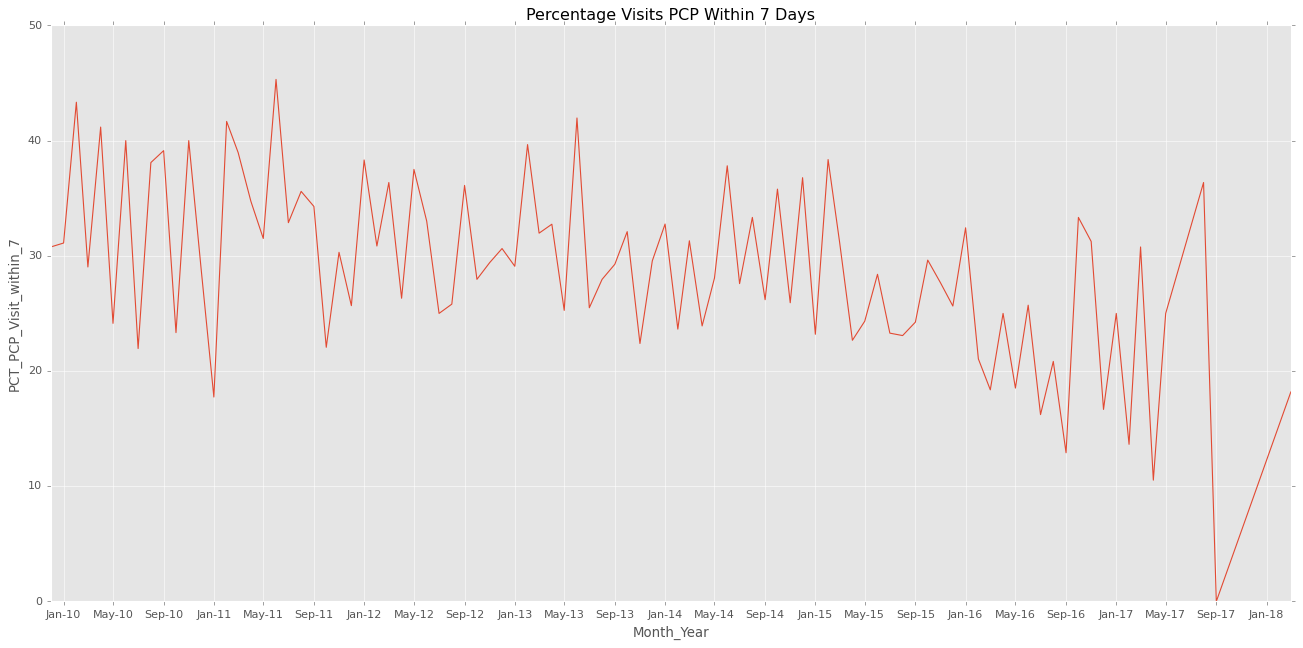

In [102]:
fig, ax1 = plt.subplots(figsize=(20,9)) # setting size of graph area
# ax2 = ax1.twinx() # plotting 2 y axis, sharing 1 x axis
# plt.style.use('ggplot')


ax1.plot(tttt['month_year'],tttt['pct_pcp_visit']) 
# ax2.bar(tttt['month_year'], tttt['total_hospital_encounters'])


ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))

plt.title("Percentage Visits PCP Within 7 Days")
ax1.set_xlabel("Month_Year")
ax1.set_ylabel('PCT_PCP_Visit_within_7')


# plt.savefig('../assets/pcp_visits_by_month.png')

Let's try with a bubble chart

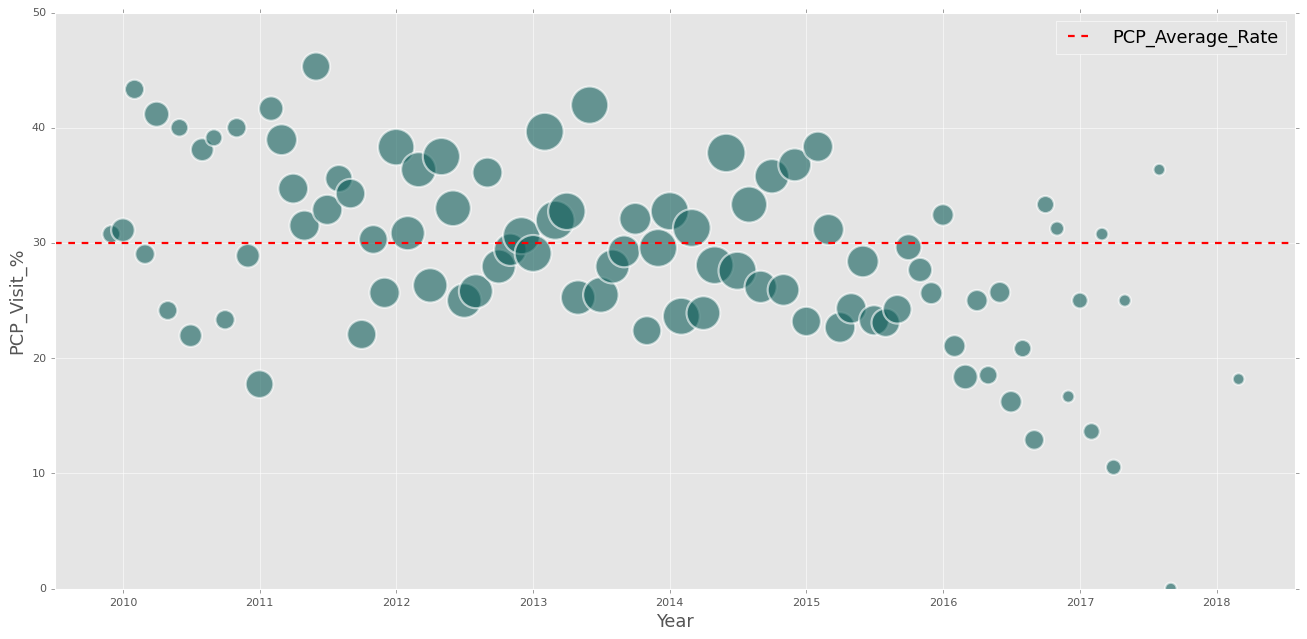

In [126]:
plt.figure(figsize=(20,9))
plt.style.use('ggplot')

plt.scatter(
    x = tttt['month_year'],
    y = tttt['pct_pcp_visit'],
    s = tttt['total_hospital_encounters']*10,
    c = '#0e5d59',
    alpha = 0.6,
    edgecolor = 'white',
    linewidth = 2)
 
plt.axhline(
    pcp_rate, 
    c='r',
    linewidth=2,
    ls = '--',
    label = 'PCP_Average_Rate')

plt.xlabel("Year", fontsize=16)
plt.ylabel("PCP_Visit_%", fontsize=16)
plt.legend(fontsize=16)
plt.ylim(bottom=0)

plt.savefig('../assets/pcp_visits_by_month_bubble.png')

# Time to bubble chart the 30RR 

In [127]:
readmission_30

,Encounter ID,Patient ID,Encounter Primary Payor ID,Encounter Primary Plan ID,Facility Provider ID,Attending Provider ID,Attending Provider NPI,Facility Provider NPI,Encounter Start Date,Encounter End Date,...,Principal Discharge Diagnosis ICD-9-CM Code,Principal Discharge Diagnosis ICD-9-CM Description,Principal Discharge Diagnosis ICD-10-CM Code,Principal Discharge Diagnosis ICD-10-CM Description,Primary Plan Allowed Amount,Primary Plan Paid Amount,Patient Paid Amount,next_admin,time_diff,within_30
0,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,DS1|1,DS1|5047W,DS1|NPI|1306890389,DS1|NPI|1417170523,1.417171e+09,1306890389,2013-01-12,2013-01-14,...,NaN,NaN,O70.0,First degree perineal laceration during delivery,0,6620.72,250.0,NaT,NaT,no
1,HIA|DS1|10043|DS1|NPI|1902803315|1,DS1|10043,DS1|1,DS1|5047Y,DS1|NPI|1902803315,DS1|NPI|1669599197,1.669599e+09,1902803315,2014-01-05,2014-01-12,...,348.4,Compression of brain,NaN,NaN,0,46465.40,250.0,NaT,NaT,no
2,HIA|DS1|10073|DS1|NPI|1902803315|1,DS1|10073,DS1|1,DS1|5047X,DS1|NPI|1902803315,DS1|NPI|1407880511,1.407881e+09,1902803315,2012-06-13,2012-06-21,...,NaN,NaN,K91.71,Accidental puncture and laceration of a digest...,0,43879.13,250.0,NaT,NaT,no
3,HIA|DS1|10101|DS1|NPI|1427055839|1,DS1|10101,DS1|1,DS1|5047W,DS1|NPI|1427055839,DS1|NPI|1407008907,1.407009e+09,1427055839,2012-12-06,2012-12-09,...,NaN,NaN,O70.1,Second degree perineal laceration during delivery,0,14800.00,250.0,NaT,NaT,no
4,HIA|DS1|10118|DS1|NPI|1992818256|1,DS1|10118,DS1|1,DS1|5047W,DS1|NPI|1992818256,DS1|NPI|1518045608,1.518046e+09,1992818256,2015-03-11,2015-03-14,...,NaN,NaN,F32.9,"Major depressive disorder, single episode, uns...",0,0.00,0.0,NaT,NaT,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6208,HIA|DS1|9979|DS1|NPI|1689772592|1,DS1|9979,DS1|1,DS1|5047X,DS1|NPI|1689772592,DS1|NPI|1720043417,1.720043e+09,1689772592,2015-02-06,2015-02-11,...,NaN,NaN,O44.13,"Complete placenta previa with hemorrhage, thir...",0,23598.00,250.0,NaT,NaT,no
6209,HIA|DS1|9981|DS1|NPI|1427055839|1,DS1|9981,DS1|1,DS1|5047W,DS1|NPI|1427055839,DS1|NPI|1215968474,1.215968e+09,1427055839,2014-08-07,2014-08-10,...,664.11,"Second-degree perineal laceration, delivered, ...",NaN,NaN,0,14800.00,250.0,NaT,NaT,no
6210,HIA|DS1|9994|DS1|NPI|1689608150|1,DS1|9994,DS1|1,DS1|5047W,DS1|NPI|1689608150,DS1|NPI|1861831836,1.861832e+09,1689608150,2015-11-21,2015-11-23,...,NaN,NaN,O76,Abnormality in fetal heart rate and rhythm com...,0,17919.75,250.0,2015-11-24,1 days,yes
6211,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,DS1|1,DS1|5047W,DS1|NPI|1689608150,DS1|NPI|1750544516,1.750545e+09,1689608150,2015-11-24,2015-11-27,...,NaN,NaN,O42.92,"Full-term premature rupture of membranes, unsp...",0,19919.42,250.0,NaT,NaT,no


In [133]:
ee = readmission_30[['Encounter ID', 'Encounter Start Date', 'Encounter End Date', 'within_30']]
ee['hospital month'] = ee['Encounter End Date'].dt.month
ee['hospital year'] = ee['Encounter End Date'].dt.year
ee['hospital year'] = ee['hospital year'].astype(str)

ee['hospital month'] = ee['hospital month'].apply(lambda x: calendar.month_abbr[x])
ee['month_year'] = ee['hospital month'] + " - " + ee['hospital year']

<ipython-input-133-fd91dc2ce289>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ee['hospital month'] = ee['Encounter End Date'].dt.month
<ipython-input-133-fd91dc2ce289>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ee['hospital year'] = ee['Encounter End Date'].dt.year
<ipython-input-133-fd91dc2ce289>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

In [134]:
ee

,Encounter ID,Encounter Start Date,Encounter End Date,within_30,hospital month,hospital year,month_year
0,HIA|DS1|10033|DS1|NPI|1306890389|1,2013-01-12,2013-01-14,no,Jan,2013,Jan - 2013
1,HIA|DS1|10043|DS1|NPI|1902803315|1,2014-01-05,2014-01-12,no,Jan,2014,Jan - 2014
2,HIA|DS1|10073|DS1|NPI|1902803315|1,2012-06-13,2012-06-21,no,Jun,2012,Jun - 2012
3,HIA|DS1|10101|DS1|NPI|1427055839|1,2012-12-06,2012-12-09,no,Dec,2012,Dec - 2012
4,HIA|DS1|10118|DS1|NPI|1992818256|1,2015-03-11,2015-03-14,no,Mar,2015,Mar - 2015
...,...,...,...,...,...,...,...
6208,HIA|DS1|9979|DS1|NPI|1689772592|1,2015-02-06,2015-02-11,no,Feb,2015,Feb - 2015
6209,HIA|DS1|9981|DS1|NPI|1427055839|1,2014-08-07,2014-08-10,no,Aug,2014,Aug - 2014
6210,HIA|DS1|9994|DS1|NPI|1689608150|1,2015-11-21,2015-11-23,yes,Nov,2015,Nov - 2015
6211,HIA|DS1|9994|DS1|NPI|1689608150|2,2015-11-24,2015-11-27,no,Nov,2015,Nov - 2015


In [139]:
trh = ee.groupby(['month_year']).within_30.count().reset_index(name='Count')
trh = trh.rename(columns={"Count": "Hospital_Count"})
print(trh)
efg = ee[ee['within_30'] == 'yes']
efg = efg.groupby(['month_year']).within_30.count().reset_index(name='Count')
efg = efg.rename(columns={"Count": "readmitted_within_30_days"})
print(efg)

     month_year  Hospital_Count
0    Apr - 2010              51
1    Apr - 2011              72
2    Apr - 2012              95
3    Apr - 2013             113
4    Apr - 2014              92
..          ...             ...
109  Sep - 2014              84
110  Sep - 2015              66
111  Sep - 2016              31
112  Sep - 2017              11
113  Sep - 2018               2

[114 rows x 2 columns]
    month_year  readmitted_within_30_days
0   Apr - 2010                         10
1   Apr - 2011                          7
2   Apr - 2012                         12
3   Apr - 2013                         10
4   Apr - 2014                          9
..         ...                        ...
90  Sep - 2013                          7
91  Sep - 2014                         13
92  Sep - 2015                          8
93  Sep - 2016                          6
94  Sep - 2017                          3

[95 rows x 2 columns]


In [141]:
qqqq = trh.merge(efg, how = 'left', on = 'month_year')


In [148]:
qqqq.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114 entries, 0 to 113
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   month_year                 114 non-null    datetime64[ns]
 1   Hospital_Count             114 non-null    float64       
 2   readmitted_within_30_days  95 non-null     float64       
 3   pct_readmitted_30_days     95 non-null     float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 4.5 KB


In [154]:
qqqq['month_year'] = pd.to_datetime(qqqq['month_year'])
qqqq['Hospital_Count'] = qqqq['Hospital_Count'].astype('float')
qqqq['pct_readmitted_30_days'] = qqqq['readmitted_within_30_days']/qqqq['Hospital_Count']*100
qqqq= qqqq[qqqq['Hospital_Count']>=10]

In [155]:
qqqq

,month_year,Hospital_Count,readmitted_within_30_days,pct_readmitted_30_days
0,2010-04-01,51.0,10.0,19.607843
1,2011-04-01,72.0,7.0,9.722222
2,2012-04-01,95.0,12.0,12.631579
3,2013-04-01,113.0,10.0,8.849558
4,2014-04-01,92.0,9.0,9.782609
...,...,...,...,...
108,2013-09-01,82.0,7.0,8.536585
109,2014-09-01,84.0,13.0,15.476190
110,2015-09-01,66.0,8.0,12.121212
111,2016-09-01,31.0,6.0,19.354839


(0.0, 30.0)

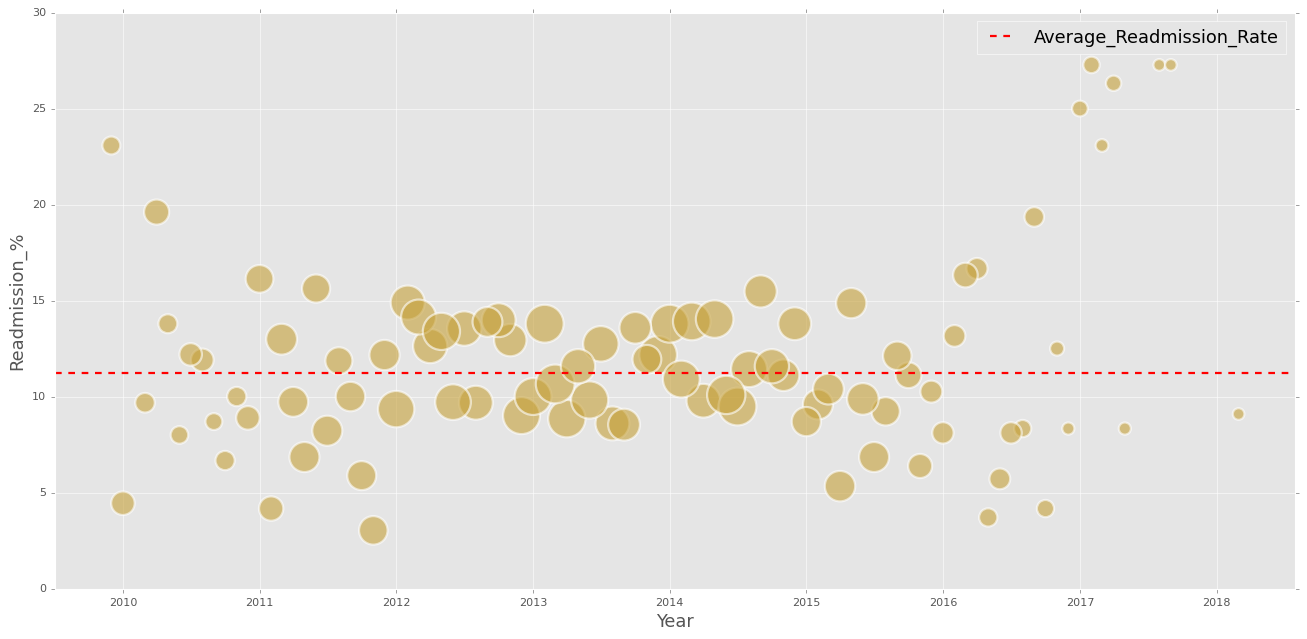

In [157]:
plt.figure(figsize=(20,9))
plt.style.use('ggplot')

plt.scatter(
    x = qqqq['month_year'],
    y = qqqq['pct_readmitted_30_days'],
    s = qqqq['Hospital_Count']*10,
    c = '#c6a139',
    alpha = 0.6,
    edgecolor = 'white',
    linewidth = 2)
 
plt.axhline(
    readmit_rate, 
    c='r',
    linewidth=2,
    ls = '--',
    label = 'Average_Readmission_Rate')

plt.xlabel("Year", fontsize=16)
plt.ylabel("Readmission_%", fontsize=16)
plt.legend(fontsize=16)
plt.ylim(bottom=0)